# import stuff

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, re, math, sklearn, json, gensim
import pickle as pkl
from collections import Counter, OrderedDict
from itertools import islice

this_directory = os.path.dirname(os.path.realpath('__file__')) # relative paths stopped working for some reason
data_directory = this_directory + '\\data\\'
processed_data_directory = data_directory + 'processed data\\'
model_directory = data_directory + 'models\\'

In [2]:
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer, HashingVectorizer
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.linear_model import Ridge, LinearRegression, SGDRegressor, LogisticRegression
from sklearn import datasets, tree, utils
from sklearn import model_selection, ensemble
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.cluster import KMeans

from gensim import matutils
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
import gensim.downloader
import gensim.parsing.preprocessing as gsp

In [3]:
import praw
from praw.models import MoreComments

In [4]:
from yelpapi import YelpAPI
# get yelp api key stored in txt file
f = open(data_directory + 'yelp_api_key.txt','r')
api_key = f.read()
f.close()

In [5]:
import spacy
nlp = spacy.load("en_core_web_sm")
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.naive_bayes import MultinomialNB

In [6]:
def transpose_lol(lol):
    """
        Transposes a list of lists.
    """
    return list(map(list,zip(*lol)))

In [7]:
def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

# overview

This notebook makes a model for individual reviews, taking in one review and spitting out a number that represents how 'clean' the reviewer thinks the restaurant is.

Each restaurant has a few inspection scores, so we *could* use the inspection scores (0-100) to train the model. But, the majority of reviews simply don't talk about the cleanliness of the restaurant, so the inspection score doesn't say much about the individual reviewer's experience.

We can instead treat the individual review model as an **unsupervised** problem to pick out reviews that specifically mention how dirty/clean the restaurant is. This could be simple bag of words and using word2vec to compare all words against a select few 'DIRTY WORDS,' or do something more complicated with contextual models.

In [7]:
df = pd.read_csv(processed_data_directory + 'reviews_nearest_score_no_limit_df.csv')
# df = pd.read_csv(processed_data_directory + 'reviews_nearest_score_2_years_df.csv')

# supervised model with bag of words (tfidf)

## clean reviews

In [8]:
yy = np.array(df['Score'])
print(f'{sum(yy%1 != 0.0)}/{len(yy)} ({sum(yy%1 != 0.0)/len(yy)*100}%) are fractional scores')

4184/570614 (0.7332452410911755%) are fractional scores


In [9]:
reviews = np.array(df['text'])
scores = np.array(df['Score'])
X, y = reviews, scores
# round
roundby = 1
y = np.array(list(map(lambda x: math.ceil(x / roundby) * roundby,y)))
# classify into two categories
# thresh = 80
# y = np.array(list(map(lambda x: 1 if x > thresh else 0, y)))

In [10]:
len(X)

570614

In [11]:
## clean up text
STOP_WORDS = STOP_WORDS.union({'ll', 've','it\'d','s','d','itd','m','nt','im','ive'}) # there's probably a better way to do this

def text_cleaner(s):
    # s = ' '.join(w.lemma_ for w in nlp(s) if not w.is_stop) # remove stop words and lemmatize
    s = re.sub('<[^<]+?>', '', s) # remove tags
    s = re.sub('[^a-z\s\n]', '', s.lower())
    # gensim is a lot faster than spacy
    s = gsp.remove_stopwords(s)
    # s = gsp.stem_text(s)
    s = re.sub("\s+"," ",s) # remove extra whitespace
    # s = s.strip()
    return s.split()

In [12]:
X[0]

"We went tonight following our favorite new Sushi chef, Felix, only to find out it was their soft opening. I'll be dam, we were properly blown away. The ambiance was simple and elegent, the staff attentive and the chefs, (Felix, Ronnie, Johnny) were wonderful. \nWe trusted Felix to generate our menu and we were not dissapointed. The highlight to our own pallets being his version of a dish called Lady Fingers. \nEverything was fresh and simple with twists of baked garlic and truffle oil. Probably one of the best times my taste bids have had in a sushi bar. \nThis is our new go-to place."

In [13]:
text_cleaner(X[0])

['went',
 'tonight',
 'following',
 'favorite',
 'new',
 'sushi',
 'chef',
 'felix',
 'soft',
 'opening',
 'ill',
 'dam',
 'properly',
 'blown',
 'away',
 'ambiance',
 'simple',
 'elegent',
 'staff',
 'attentive',
 'chefs',
 'felix',
 'ronnie',
 'johnny',
 'wonderful',
 'trusted',
 'felix',
 'generate',
 'menu',
 'dissapointed',
 'highlight',
 'pallets',
 'version',
 'dish',
 'called',
 'lady',
 'fingers',
 'fresh',
 'simple',
 'twists',
 'baked',
 'garlic',
 'truffle',
 'oil',
 'probably',
 'best',
 'times',
 'taste',
 'bids',
 'sushi',
 'bar',
 'new',
 'goto',
 'place']

In [14]:
# simple bag of words
bow_vectorizer = TfidfVectorizer(tokenizer=text_cleaner,
                                 min_df=10,
                                 max_df=0.5,
                                 max_features=20000,
                                 ngram_range=(1,2),
                                 stop_words=STOP_WORDS)
# svd = TruncatedSVD(n_components=100)
features = Pipeline([
    ('tfidf',bow_vectorizer),
    ('svd',TruncatedSVD(n_components=200)),
    ('minmax',MinMaxScaler(feature_range=(0,1))) # necessary for NB
])

In [20]:
%%time
X_out = features.fit_transform(X,y)

CPU times: total: 2min 26s
Wall time: 1min 43s


In [21]:
# looking at high tf-idf terms
high_value_terms = dict(zip(features.named_steps.tfidf.vocabulary_, features.named_steps.tfidf.idf_))
high_value_terms = dict(sorted(high_value_terms.items(), key=lambda item: item[1],reverse=True))
high_value_terms

{'egg yolk': 10.565590551419845,
 'got breakfast': 10.034962300357675,
 'stiff': 9.711175223263776,
 'clients': 9.65935015539919,
 'cuisine': 9.572338778409561,
 'order comes': 9.553989639741365,
 'meantime': 9.52708218682144,
 'tacos good': 9.509537877170532,
 'great fries': 9.500879814427416,
 'run': 9.466978262751734,
 'december': 9.45867945993704,
 'obscure': 9.45867945993704,
 'drank': 9.434188439928745,
 'flavor tried': 9.434188439928745,
 'bruschetta': 9.41028291907519,
 'sushi rice': 9.402439741614163,
 'came large': 9.402439741614163,
 'sandwich ordered': 9.394657601172108,
 'like salsa': 9.386935555078198,
 'brittle': 9.37166808294741,
 'dumped': 9.37166808294741,
 'drive window': 9.364120877312027,
 'good know': 9.356630205582869,
 'best restaurant': 9.34181511979773,
 'expect': 9.334489079705657,
 'accessible': 9.327216320376577,
 'ordered regular': 9.327216320376577,
 'tastes fresh': 9.327216320376577,
 'scream': 9.327216320376577,
 'waitlist': 9.327216320376577,
 'kombuch

In [22]:
X_out_shuff, y_shuff = shuffle(X_out, y, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_out_shuff, y_shuff, test_size=0.2)

In [23]:
model_directory

'C:\\Users\\fanga\\OneDrive\\Documents\\git stuff\\yelp-cleaners\\data\\models\\'

In [24]:
# save to file
filename = model_directory + 'review_model\\supervised_features.pkl'
pkl.dump(features, open(filename,'wb'))

make sure pickling worked

In [25]:
filename = model_directory + 'review_model\\supervised_features.pkl'
loaded_features = pkl.load(open(filename, 'rb'))

In [26]:
X_out_2 = loaded_features.transform(X)

In [27]:
# they're the same, so pickling works
sum(sum(X_out - X_out_2))

2.7373936450914016e-14

## regressor

In [28]:
def test_regressor(regressor,print_R2=True,residual_hist=True,predictions_hist=True):
    regressor.fit(X_train,y_train)
    if print_R2:
        print(f'R^2 score: {regressor.score(X_test, y_test)}')
    y_predict = regressor.predict(X_test)
    if residual_hist:
        fig = plt.figure(1)
        plt.hist(y_predict-y_test,bins=30,alpha=0.5);
        plt.show()
    if predictions_hist:
        fig = plt.figure(2)
        plt.hist(y_predict,bins=30,alpha=0.5)
        plt.hist(y_test,bins=30,alpha=0.5)
        plt.show()

R^2 score: 0.12101511169588486


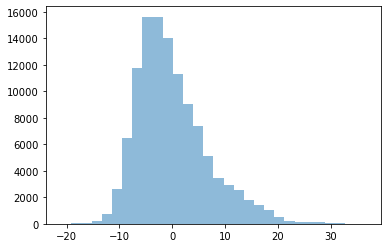

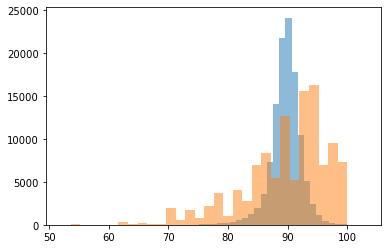

CPU times: total: 6.62 s
Wall time: 1.48 s


In [29]:
%%time
regressor = Ridge(alpha=10)
test_regressor(regressor)

In [30]:
%%time
parameters = {
    'alpha': [0.01,0.1,1,10]
}
gs = GridSearchCV(regressor, parameters)
gs.fit(X_test,y_test)
gs.best_params_

CPU times: total: 30.2 s
Wall time: 5.12 s


{'alpha': 10}

In [31]:
# %%time
# regressor = LogisticRegression(solver = 'lbfgs', max_iter=100)
# test_regressor(regressor)

In [32]:
filename = model_directory + 'review_model\\supervised_model_ridge.pkl'
pkl.dump(regressor, open(filename,'wb'))

# word2vec

## first pass: word2vec on our dataset

First try to find a vocabulary of "dirty words" with word2vec on the actual dataset.

### full dataset

In [ ]:
# number of reviews per stars
df.groupby('review_stars').count()[['text']]

,text
review_stars,
1,56106
2,48516
3,67216
4,147908
5,250868


In [ ]:
# only look at reviews with 1-2 stars for restaurants with poor inspections
dff = df[(df['review_stars']<=2) & (df.Score < 80.0)].copy().reset_index(drop=True)[['text','Score','review_stars']]
print(f'Corpus contains {len(dff)}/{len(df)} reviews ({round(len(dff)/len(df)*100,2)}%)')
corpus = dff['text'].values

Corpus contains 12107/570614 reviews (2.12%)


In [123]:
corpus = df['text'].values

In [124]:
test = corpus[812]
test

"On a whim at 10:30 pm on a post-holiday weekday, we decided to give Halal Bros a try.  I've had my fair share of Mediterranean foods, and I can say Halaal Bros had some GREAT food and equally great service!\n\nWe had the falafel plate and lamb shawarma over rice.  Both plates were of exceptional quality and taste.  The falafel was crisp, hot, and flavorful, the accompanying sides were fresh, and some of the best hummus ever.  The lamb shawarma was hearty, but not heavy, with an amazing flavor of the lamb coming through the heavily spiced dish.  All this great food at a great value.  \n\nThe only minor drawback I experienced was that the pita bread was a bit hard and chewy - probably from sitting in the foil wrapper under a warmer too long.  That minor issue aside, Halal Bros is now my go-to for Mediterranean.  Welcome to the neighborhood!"

In [125]:
## clean up text
STOP_WORDS = STOP_WORDS.union({'ll', 've','it\'d','s'})

def text_cleaner(s):
    # s = ' '.join(w.lemma_ for w in nlp(s) if not w.is_stop) # remove stop words and lemmatize
    s = re.sub('<[^<]+?>', '', s) # remove tags
    s = re.sub('[^a-z\s\n]', '', s.lower())
    # gensim is a lot faster than spacy
    s = gsp.remove_stopwords(s)
    # s = gsp.stem_text(s)
    s = re.sub("\s+"," ",s) # remove extra whitespace
    # s = s.strip()
    return s.split()

In [126]:
%%time
text_cleaner(corpus[812])

CPU times: total: 0 ns
Wall time: 0 ns


['whim',
 'pm',
 'postholiday',
 'weekday',
 'decided',
 'halal',
 'bros',
 'try',
 'ive',
 'fair',
 'share',
 'mediterranean',
 'foods',
 'halaal',
 'bros',
 'great',
 'food',
 'equally',
 'great',
 'service',
 'falafel',
 'plate',
 'lamb',
 'shawarma',
 'rice',
 'plates',
 'exceptional',
 'quality',
 'taste',
 'falafel',
 'crisp',
 'hot',
 'flavorful',
 'accompanying',
 'sides',
 'fresh',
 'best',
 'hummus',
 'lamb',
 'shawarma',
 'hearty',
 'heavy',
 'amazing',
 'flavor',
 'lamb',
 'coming',
 'heavily',
 'spiced',
 'dish',
 'great',
 'food',
 'great',
 'value',
 'minor',
 'drawback',
 'experienced',
 'pita',
 'bread',
 'bit',
 'hard',
 'chewy',
 'probably',
 'sitting',
 'foil',
 'wrapper',
 'warmer',
 'long',
 'minor',
 'issue',
 'aside',
 'halal',
 'bros',
 'goto',
 'mediterranean',
 'welcome',
 'neighborhood']

In [127]:
%%time
corpus_cleaned = list(map(text_cleaner,corpus))

CPU times: total: 18.9 s
Wall time: 18.9 s


In [128]:
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
import gensim.downloader

In [142]:
w2v = Word2Vec(min_count=5, window=5, vector_size=100, workers=-1, sg=0)

In [143]:
%%time
w2v.build_vocab(corpus_cleaned)

CPU times: total: 3.62 s
Wall time: 3.62 s


In [144]:
# these words don't make any sense
w2v.wv.most_similar('gross')

[('bratstickers', 0.40365973114967346),
 ('shoveled', 0.4010236859321594),
 ('lettucetomato', 0.3780089318752289),
 ('poached', 0.37607064843177795),
 ('unsurpassed', 0.3732072114944458),
 ('mentioning', 0.35862767696380615),
 ('micro', 0.35573577880859375),
 ('popups', 0.35506248474121094),
 ('investigate', 0.3541969954967499),
 ('sambets', 0.35137274861335754)]

In [151]:
print(w2v.wv.similarity('nasty','dirty'))
print(w2v.wv.similarity('nasty','clean'))
print(w2v.wv.similarity('dirty','clean'))

-0.13580632
-0.31347013
0.18907271


### subset of dataset

Full dataset doesn't work at all. Results are nonsense. Let's try only looking at 1-2 star reviews on restaurants with poor scores.

In [152]:
# number of reviews per stars
df.groupby('review_stars').count()[['text']]

,text
review_stars,
1,56106
2,48516
3,67216
4,147908
5,250868


In [153]:
# only look at reviews with 1-2 stars for restaurants with poor inspections
dff = df[(df['review_stars']<=2) & (df.Score < 80.0)].copy().reset_index(drop=True)[['text','Score','review_stars']]
print(f'Corpus contains {len(dff)}/{len(df)} reviews ({round(len(dff)/len(df)*100,2)}%)')
corpus = dff['text'].values

Corpus contains 12107/570614 reviews (2.12%)


In [155]:
## clean up text
STOP_WORDS = STOP_WORDS.union({'ll', 've','it\'d','s'})

def text_cleaner(s):
    # s = ' '.join(w.lemma_ for w in nlp(s) if not w.is_stop) # remove stop words and lemmatize
    s = re.sub('<[^<]+?>', '', s) # remove tags
    s = re.sub('[^a-z\s\n]', '', s.lower())
    # gensim is a lot faster than spacy
    s = gsp.remove_stopwords(s)
    # s = gsp.stem_text(s)
    s = re.sub("\s+"," ",s) # remove extra whitespace
    # s = s.strip()
    return s.split()

In [156]:
%%time
corpus_cleaned = list(map(text_cleaner,corpus))

CPU times: total: 844 ms
Wall time: 843 ms


In [157]:
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
import gensim.downloader

In [158]:
w2v = Word2Vec(min_count=5, window=5, vector_size=100, workers=-1, sg=0)

In [159]:
%%time
w2v.build_vocab(corpus_cleaned)

CPU times: total: 188 ms
Wall time: 189 ms


In [173]:
# these words don't make any sense
w2v.wv.most_similar('undercooked')

[('ends', 0.3598881959915161),
 ('ding', 0.33352720737457275),
 ('feeding', 0.32537519931793213),
 ('grade', 0.3236634135246277),
 ('pudding', 0.31773656606674194),
 ('braided', 0.3091064393520355),
 ('easter', 0.30147871375083923),
 ('milanesa', 0.29708123207092285),
 ('choosing', 0.2929005026817322),
 ('efforts', 0.2848978042602539)]

In [170]:
print(w2v.wv.similarity('nasty','dirty'))
print(w2v.wv.similarity('nasty','clean'))
print(w2v.wv.similarity('dirty','clean'))

-0.068202436
-0.10094115
-0.040756043


## word2vec on reddit AMA data

There are a few reddit AMA threads asking health inspectors about the grossest things they've seen. This should be relevant.

Gathering a corpus to describe dirty restaurants from reddit posts by health inspectors talking about their worst ever experiences:
* https://www.reddit.com/r/AskReddit/comments/1lnddh/health_inspectors_of_reddit_what_is_the_worst/
* https://www.reddit.com/r/AskReddit/comments/2h1uuq/food_inspectors_of_reddit_whats_the_worst/

Following this helpful guide: https://towardsdatascience.com/scraping-reddit-data-1c0af3040768

And this post: https://stackoverflow.com/questions/60623349/how-to-limit-first-level-comments-in-praw-reddit

In [8]:
import praw
from praw.models import MoreComments
f = open(data_directory + 'reddit_api_key.txt','r')
r_client_id, r_secret, r_user_agent = [line.strip() for line in f.readlines()]
f.close()
reddit = praw.Reddit(client_id=r_client_id, client_secret=r_secret, user_agent=r_user_agent)

In [9]:
# get all top-level comments in a post
def iter_top_level(comments):
    for top_level_comment in comments:
        if isinstance(top_level_comment, MoreComments):
            yield from iter_top_level(top_level_comment.comments())
        else:
            yield top_level_comment

def get_reddit_comments(post_id="1lnddh"):
    submission = reddit.submission(post_id)
    comments = []
    for comment in iter_top_level(submission.comments): 
        # only get NON-deleted posts with >5 score
        if comment.author and comment.score > 5:
            comments.append(comment.body)
    return comments

In [15]:
%%time
# this no longer works for some reason, need to debug
# comments = []
# post_ids = ["1lnddh","2h1uuq","598qrb"]
# for i in post_ids:
#     comments += get_reddit_comments(i)

CPU times: total: 0 ns
Wall time: 0 ns


In [35]:
reddit_comments = pd.read_csv(processed_data_directory + 'reddit_comments.csv')
corpus = reddit_comments['comments'].values

In [36]:
## clean up text
STOP_WORDS = STOP_WORDS.union({'ll', 've','it\'d','s'})

def remove_URL(s):
    """Remove URLs from a sample string"""
    return re.sub(r"http\S+", "", s)
def text_cleaner(s):
    # s = ' '.join(w.lemma_ for w in nlp(s) if not w.is_stop) # remove stop words and lemmatize
    s = re.sub('<[^<]+?>', '', s) # remove tags
    s = re.sub('[^a-z\s\n]', '', s.lower())
    # gensim is a lot faster than spacy
    s = remove_URL(s)
    s = gsp.remove_stopwords(s)
    # s = gsp.stem_text(s)
    s = re.sub("\s+"," ",s) # remove extra whitespace
    # s = s.strip()
    return s.split()

In [37]:
%%time
corpus_cleaned = list(map(text_cleaner,corpus))

CPU times: total: 15.6 ms
Wall time: 10 ms


In [47]:
w2v = Word2Vec(min_count=5, window=5, vector_size=1000, workers=-1, sg=0)

In [48]:
%%time
w2v.build_vocab(corpus_cleaned)

CPU times: total: 15.6 ms
Wall time: 12 ms


In [63]:
w2v.wv.most_similar('nasty')

[('directly', 0.10089504718780518),
 ('feel', 0.08105595409870148),
 ('known', 0.07953879982233047),
 ('plus', 0.07718612998723984),
 ('water', 0.06897077709436417),
 ('reddit', 0.06876303255558014),
 ('boots', 0.0679335743188858),
 ('pay', 0.06747064739465714),
 ('hours', 0.06590712815523148),
 ('deal', 0.06542625278234482)]

In [54]:
print(w2v.wv.similarity('nasty','dirty'))
print(w2v.wv.similarity('nasty','clean'))
print(w2v.wv.similarity('dirty','clean'))

0.038409777
0.03936795
0.006311542


# pre-trained glove

Our dataset is too small and mostly irrelevant, so we can't generate a great vocabulary from word2vec. I'll go grab a pre-trained vocab/word vector like GloVe: https://nlp.stanford.edu/projects/glove/

Conveniently, GloVe is readily available through gensim: https://github.com/RaRe-Technologies/gensim-data

Here are some reviews I got from a gross restaurant: https://www.yelp.com/biz/pacific-star-restaurant-and-oyster-bar-round-rock-3. I expect the bad reviews to be rated pretty lowly. I don't really care about the analysis on the good reviews.

In [10]:
good_reviews = [r"They have some of the best seafood I've ever eaten here in Austin. I usually always order the same thing, but it never fails to be delicious. Their employees are all very nice too. They're clean, and the service is always quick, while never feeling rushed.",
                r"We ordered the shrimp and oyster platter, broiled snapper plate and oysters diablos. Everything was delish but them oysters diablos were the bomb.com. We recommend ordering them every time. Service was good. The restaurant was clean.",
                r"Great food, great service, great prices! It's hard to believe it's the same place that some of the negative reviews are referring to. Seafood is always fresh and the beer is always cold!",
                r"Was undecided about going based on some reviews but decided to give it a try and so glad we did. Seafood was made to order and came out hot and fresh.  Service was very good. Food was very good. Price was very reasonable. I recommend and will be back.",
                r"Very good food.  We had the shrimp poboy and there was shrimp in every bite.  The bun was freshly baked which only enhanced the taste.  The gumbo was delicious too.  The atmosphere is warm and friendly and the people are super friendly.  All in all, a positive dining experience.  I will return.",
                r"The interior was very clean and had yummy aromas circulating.  I can definitely see why there is a 'sports-bar' vibe mentioned in some of the reviews.  Two TVs going, both with sports, lots of men with beer sitting around the central bar.  I think i was the only female in the place. The daily special was grilled flounder with a crab-shrimp brandy cream sauce.  Very, very tasty.  My son ordered this, and i swiped a bite of the fish, and two bites of the most excellent grilled veggies on the side.  Large platter, fitting the price.  I'd eat a veggie plate, if the grilled squash/onions/zucchini/mushrooms were the star!",
                r"Amazing! Very fresh, and they tasted good too. I did douse them with lemon, a little seafood sauce, and Tabasco sauce though.  I also washed them down with my ice cold beer!  If you an get past the texture, you'll be ok. There was no shortage of saltine crackers. I did see someone with a large shrimp cocktail that I would like to try next time. Overall a very good experience. When my raw oyster on the half shell craving returns, I will be back to this place to satisfy it."
               ]

In [11]:
bad_reviews = [r"This place was absolutely disgusting. We considered turning around as soon as we walked in as it had an odd vibe, unpleasant smell and almost no customers. BUT I've been to my fair share of decent dive type spots so we decided we'd stick around and give it a chance. The sweet tea was great, but all of the food was inedible. Clearly frozen calamari tasted like fried rubber bands with several of the pieces looking questionable and moldy. The fried catfish looked like cafeteria/hospital food. It too was obviously just frozen (freezer burned) catfish they threw in the fryer along with kindergarten crinkle fries and crunchy hush puppies. I honestly couldn't even eat my food both because it was gross and in fear of getting sick. I forced myself to throw up as soon as I got home and I wish I was kidding. The worst part is that the bill was $40 for two entrees and and appetizer which is absolutely insane considering the quality of what they put in front of us. I wish I'd gone to Long John Silvers on my way in the parking lot instead. I absolutely do not recommend this place whatsoever.",
               r"Horrible service, dirty facility; I gave them 2 stars because the catfish nuggets were pretty good and the wine was cold. When asking for the check; our server asked my husband to write down everything we ordered so he could create a receipt; I'm still confused by this because no one else at our table had to do that. Weird anyway; I'll never go back there.",
               r"We came on a Friday evening and parking lot was full so it seemed promising however we were clearly mistaken. The dining room is fairly small and we were able to snag a table by the entrance. The table had not wiped down so there was still water rings and food crumbs from the previous person. We wiped down the table ourselves and waited for our server. 10 mins later no one came by the table. No one even looked in our direction. Was this a walk up to the bar and order yourself place? Who knows. There was what appeared to be a waitress offering menus to other tables. We left without even having anything so we can't comment on the food but unfortunately we won't be returning.",
               r"Literally the most disgusting restaurant experience I've ever had. First of all our server did NOT wear a mask. She was rude as hell and downright didn't even know the menu. The food that came out was over cooked flounder that we didn't even eat. Actually spit the food into my napkin. Wouldn't wish this place on my worst enemy.",
               r"Let me start w ordering. I ordered online. Got to the place to pick up my food then bam... my order wasn't ready. They couldn't even find my order. They thought I placed it for another location. Had to show from my phone I placed to round rock location. The guy had to call someone to get my online order. Had to wait an extra 30 min. Place was crowded and big groups of families in there. The food was ok. I wasn't that impressed. I got it to go bc I don't eat in restaurants due to Covid. So by the time I made it home it tasted old. Kind of stale. Like the grease the food was fried in was not fresh. Can't say I'll be back",
               r"Expected more. Seemed dingy. Not very clean overall. Service was not up to par. They seemed to be more focus on serving those at the bar then at the tables. Our table was dirty, sticky. Menu was disgusting to the touch. The food was okay. Will not go again.",
               r"Oysters on the half were good, kinda hard to mess them up. Wife ordered broiled rainbow trout, the fish was spoiled! You could smell it once the waitress set it on the table, so either their cook has no sense of smell or they just dont care if they make someone sick. The wait staff spends more time at the bar playing on their phones than they do waiting on customers. They did wear mask but there was no social distance between tables or at the bar. Speaking of the bar, it's very loud to the point you cannot have a conversation at your table. We will definitely never go back to this place and I would not recommend it anyone else  either.",
               r"They failed health inspection with a score of 37 on December 10th, 2019. Report stated too many cockroaches to count and had rat feces in the dish area",
               r"I came here on Friday night with my family for dinner, this place is severely understaffed. And for that reason I can't find it in me to come back. All the waitstaff is running around stressing out and it shows in the quality of the food and service. It look 10 min to get greeted and welcomed, we ordered a app which came out after the food. My boyfriend ordered the crawfish that had a awful taste and smell, I ordered a shrimp salad which came with brown slimy lettuce a half of a slice of tomato and ranch dressing for 12.99 the menu said it was supposed to include more veggies so i asked for the side i was brought that and then noticed how old the lettuce was. My sisters crab cakes tasted old and no flavor whatsoever. My son ordered the chicken tenders and fries as my 2 year old is eating his food we notice a long hair inside of his food we then decided to take our complaints to the manger which told us that they are understaffed and extremely busy..... I really hope the owner of this establishment can do what needs to be done to get this place in the right track. I'm giving 2 starts for potential but I won't be back... your better off going to razzoos down the street"
              ]

## playin

### load in model

In [8]:
fake_news_info = gensim.downloader.info('glove-twitter-200')
print(json.dumps(fake_news_info, indent=4))

{
    "num_records": 1193514,
    "file_size": 795373100,
    "base_dataset": "Twitter (2B tweets, 27B tokens, 1.2M vocab, uncased)",
    "reader_code": "https://github.com/RaRe-Technologies/gensim-data/releases/download/glove-twitter-200/__init__.py",
    "license": "http://opendatacommons.org/licenses/pddl/",
    "parameters": {
        "dimension": 200
    },
    "description": "Pre-trained vectors based on 2B tweets, 27B tokens, 1.2M vocab, uncased (https://nlp.stanford.edu/projects/glove/).",
    "preprocessing": "Converted to w2v format with `python -m gensim.scripts.glove2word2vec -i <fname> -o glove-twitter-200.txt`.",
    "read_more": [
        "https://nlp.stanford.edu/projects/glove/",
        "https://nlp.stanford.edu/pubs/glove.pdf"
    ],
    "checksum": "e52e8392d1860b95d5308a525817d8f9",
    "file_name": "glove-twitter-200.gz",
    "parts": 1
}


In [8]:
gv = gensim.downloader.load('glove-twitter-200')

In [11]:
gv.most_similar('smelly')

[('stinky', 0.7768126130104065),
 ('smell', 0.6030378341674805),
 ('smells', 0.5854460000991821),
 ('sweaty', 0.5837231278419495),
 ('smelling', 0.583556592464447),
 ('dirty', 0.5677381157875061),
 ('stinks', 0.5544800162315369),
 ('stink', 0.55202716588974),
 ('hairy', 0.5441873669624329),
 ('musty', 0.5356823205947876)]

In [19]:
# glove gets a lot of stuff "right"
print(gv.similarity('clean','fresh')) # high
print(gv.similarity('clean','smelly')) # low
print(gv.similarity('nasty','smelly')) # high
print(gv.similarity('gross','disgusting')) #high

0.6442809
0.4028358
0.51351666
0.81413555


In [20]:
# one unfortunate thing is the "similarity" of direct antonyms. This is annoying.
gv.similarity('clean','dirty')

0.64746726

In [21]:
# moldy == peaches?
gv.most_similar('sick')

[('tired', 0.7939080595970154),
 ('feel', 0.7492012977600098),
 ('really', 0.734252393245697),
 ('ugh', 0.722662627696991),
 ('bad', 0.7212360501289368),
 ('seriously', 0.7186442017555237),
 ('fucking', 0.7133126258850098),
 ('getting', 0.7114008069038391),
 ('gonna', 0.7091169357299805),
 ('kinda', 0.7083275318145752)]

In [303]:
# these are a few representative words
DIRTY_WORDS = ('disgusting','smelly','rotten','nasty','gross','dirty','undercooked','moldy','puke','sick','unhealthy')
PEST_WORDS = ('rat','bugs','cockroach','fly','ant','flea','insect','infestation','infest')
CLEAN_WORDS = ('clean','pristine','immaculate','organized','fresh')
# average vector of these words
DIRTY_VECTOR = np.mean(np.array([gv[w] for w in DIRTY_WORDS]),axis=0)
PEST_VECTOR = np.mean(np.array([gv[w] for w in PEST_WORDS]),axis=0)

In [23]:
gv.most_similar(
    positive=PEST_WORDS,
    topn=10
)

[('bug', 0.6536531448364258),
 ('spider', 0.6499894857406616),
 ('rats', 0.64519202709198),
 ('moth', 0.634965181350708),
 ('spiders', 0.6280730366706848),
 ('insects', 0.6075429916381836),
 ('snakes', 0.5952991843223572),
 ('cockroaches', 0.5927811861038208),
 ('flying', 0.5927191376686096),
 ('ants', 0.5899176001548767)]

In [24]:
gv.most_similar(
    positive=DIRTY_WORDS,
    negative=CLEAN_WORDS,
    topn=10
)

[('ew', 0.669167697429657),
 ('eww', 0.6688995361328125),
 ('yuck', 0.6352888941764832),
 ('pathetic', 0.6272950768470764),
 ('awful', 0.6006811857223511),
 ('vile', 0.6005575656890869),
 ('yucky', 0.5932128429412842),
 ('minging', 0.5843111276626587),
 ('discusting', 0.5814267992973328),
 ('filthy', 0.581305980682373)]

In [68]:
# find most similar words to ALL words in DIRTY_WORDS
# averaging similar words gives weird results
list_of_dicts = [dict(gv.similar_by_word(w)) for w in DIRTY_WORDS+PEST_WORDS]
collected = {}
for d in list_of_dicts:
    for key in d:
        if key in collected:
            collected[key].append(d[key])
        else:
            collected[key] = [d[key]]
            
for key in collected:
    collected[key] = max(collected[key])

DIRTYISH_WORDS = {k: v for k, v in sorted(collected.items(), key=lambda item: item[1], reverse=True)}
take(20, DIRTYISH_WORDS.items())

[('disgusting', 0.8141355514526367),
 ('gross', 0.8141354918479919),
 ('tired', 0.7939080595970154),
 ('stinky', 0.7768126130104065),
 ('vile', 0.7741666436195374),
 ('nasty', 0.770848274230957),
 ('dirty', 0.770848274230957),
 ('ew', 0.7640780210494995),
 ('eww', 0.7570286393165588),
 ('awful', 0.7541442513465881),
 ('filthy', 0.753870964050293),
 ('feel', 0.7492012977600098),
 ('ass', 0.7464606761932373),
 ('vomit', 0.7441722750663757),
 ('flying', 0.7441135048866272),
 ('pathetic', 0.740756094455719),
 ('bug', 0.739231526851654),
 ('really', 0.734252393245697),
 ('barf', 0.726361870765686),
 ('ugh', 0.722662627696991)]

### Try clustering raw glove vocabulary

Try clustering the raw glove vocab to look for words similar to DIRTY_WORDS instead of just by distance. Not sure if this makes sense to do since the glove model already has calculated distances between all words...

In [70]:
# number of keys in the vocabulary is huge
len(gv.key_to_index)

1193514

In [278]:
X = gv.vectors
X = (X - np.min(X))/(np.max(X)-np.min(X)) # restrict to 0 to 1

In [279]:
%%time
num_clusters = 50
kmeans = KMeans(n_clusters=num_clusters,random_state=100)
kmeans.fit(X)
cluster_labels = kmeans.labels_

CPU times: total: 1h 18min 10s
Wall time: 8min 55s


In [280]:
%%time
# reduce dimensions
num_components = 5
pca = PCA(n_components=num_components, random_state=100)
matrix_pca = pca.fit_transform(gv.vectors)

CPU times: total: 20.3 s
Wall time: 4.2 s


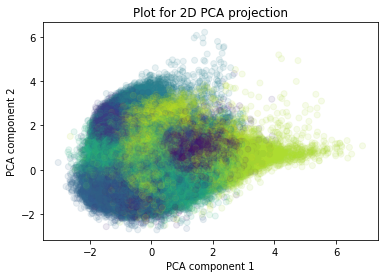

CPU times: total: 11.5 s
Wall time: 11.3 s


In [281]:
%%time
# 2D looks good
plt.scatter(matrix_pca[:,0],matrix_pca[:,1],
            alpha=0.1,c=cluster_labels,cmap='viridis')
plt.gca().set(title='Plot for 2D PCA projection', 
              xlabel='PCA component 1', ylabel='PCA component 2');
plt.show()

In [282]:
# create a dataframe to match up words to clusters
df_gv = pd.DataFrame()
df_gv['labels'] = gv.key_to_index.keys()
df_gv['cluster'] = cluster_labels
# get distance to cluster centers
cluster_distances = kmeans.transform(X).T
for idx, col in enumerate(cluster_distances):
    df_gv[f'cluster_dist_{idx}'] = col

In [283]:
# most of our DIRTY WORDS are in the same cluster (#1)
df_gv[df_gv.labels.isin(DIRTY_WORDS) | df_gv.labels.isin(PEST_WORDS)]

,labels,cluster,cluster_dist_0,cluster_dist_1,cluster_dist_2,cluster_dist_3,cluster_dist_4,cluster_dist_5,cluster_dist_6,cluster_dist_7,...,cluster_dist_40,cluster_dist_41,cluster_dist_42,cluster_dist_43,cluster_dist_44,cluster_dist_45,cluster_dist_46,cluster_dist_47,cluster_dist_48,cluster_dist_49
932,sick,43,0.641752,0.655716,0.655047,0.574556,0.658864,0.634783,0.654668,0.606688,...,0.656499,0.666259,0.555568,0.435029,0.659602,0.640834,0.661316,0.650238,0.652637,0.666522
2276,fly,43,0.654618,0.658226,0.650754,0.578180,0.655736,0.621190,0.655370,0.602783,...,0.618514,0.659293,0.584974,0.485334,0.667091,0.652619,0.641222,0.665217,0.646992,0.659163
2567,dirty,43,0.661849,0.665819,0.647049,0.583069,0.663534,0.637428,0.651803,0.637389,...,0.658934,0.670335,0.572560,0.471837,0.660823,0.654854,0.659987,0.654567,0.658526,0.675939
3313,nasty,43,0.644209,0.651100,0.642293,0.576518,0.645576,0.631181,0.640726,0.628792,...,0.644179,0.644404,0.564662,0.474037,0.646560,0.635150,0.641782,0.637493,0.636289,0.664371
5798,gross,43,0.613018,0.605962,0.619599,0.561995,0.623939,0.613196,0.622022,0.612939,...,0.622141,0.621992,0.545527,0.483624,0.621176,0.616141,0.617390,0.620724,0.604196,0.628426
6039,disgusting,43,0.637535,0.646332,0.635823,0.591876,0.647402,0.645522,0.643167,0.633158,...,0.654704,0.645844,0.553583,0.500377,0.655299,0.630895,0.645210,0.635472,0.636109,0.655656
9576,rat,43,0.595994,0.593592,0.589889,0.525472,0.600082,0.589502,0.602733,0.549756,...,0.610251,0.615986,0.535757,0.473390,0.594583,0.610834,0.609441,0.589747,0.581608,0.608664
11744,ant,43,0.541124,0.555836,0.531589,0.455936,0.529011,0.512482,0.536697,0.518218,...,0.547659,0.555775,0.476375,0.403411,0.542684,0.552972,0.547372,0.534704,0.520560,0.550690
12474,bugs,43,0.621374,0.622858,0.607648,0.552901,0.601041,0.598964,0.602364,0.607946,...,0.611269,0.620556,0.543740,0.505074,0.618886,0.607089,0.612766,0.615972,0.600753,0.625945
19656,puke,43,0.565181,0.576728,0.585621,0.526661,0.574574,0.578973,0.576169,0.578722,...,0.582468,0.582565,0.513040,0.486284,0.581620,0.584117,0.573898,0.583286,0.565270,0.580692


In [284]:
# look at the top words per cluster... these are all japanese...
num_words = 5
top_words_per_cluster = pd.DataFrame({})
for idx in range(num_clusters):
    top_words_per_cluster[f'cluster {idx}'] = df_gv.sort_values(f'cluster_dist_{idx}').labels[:num_words].values
top_words_per_cluster = top_words_per_cluster.T
top_words_per_cluster

,0,1,2,3,4
cluster 0,おかろーん,このツイート見たらrtとお願いし,もう寝るのか?おやすみ,shekf,新青梅街道沿いのragstationへ
cluster 1,万円稼いでみましょうかn,新青梅街道沿いのragstationへ,進撃の食物連鎖,おかろーん,jcjxjd
cluster 2,進撃の食物連鎖,ecigbrandstarterkitn,今日見たツボ親子,ｵｷﾀｰ!ｼｬﾝﾊｰｲ,ひき逃げされた女がいるユニットワロタ
cluster 3,uxxjxxjxjdhshsjc,iworkto,kdckddjeiqjj,ieiwosor,ckffk
cluster 4,振り向いたら二人,おいしくて太らない,おかろーん,新青梅街道沿いのragstationへ,jcjxjd
cluster 5,今度こそ失敗しないようにやらなきゃな,gooooooooooooooooooooooooooooooooooooooooooooo...,おなか空いたけどなんにもないorz,hahahahahahahahahahahahahahahahahahahahahahaha...,jajajajajajajajajajajajajajajajajajajajajajaja...
cluster 6,おかろーん,振り向いたら二人,もう寝るのか?おやすみ,jcjxjd,integrationmonitor
cluster 7,洋楽っていいよねｗ,歌詞わかんないから気を取られないでｗｗ,hahahahahahahahahahahahahahahahahahahahahahaha...,おなか空いたけどなんにもないorz,今度こそ失敗しないようにやらなきゃな
cluster 8,nagemon,誰か私のイメージイラストを描いてくれませんかなんて口が裂けても言えませんけどもし描いてくださ...,どっちも入ってる人rt,コンビニあるある思ったらrt,このcm覚えてたら絶対同世代w
cluster 9,天神なう,そうしますか,湯けむりの向こうだって俺のホークアイがあれば見え見えなんだぜ,おつかれっすー,おはありよー


Okay, a smarter thing to do is only use words in glove which also appear in our dataset. That makes a lot more sense than doing this all raw on glove.

## new sentence embeddings

### building vector-output sentence embedding

In [436]:
%%time
# import model
gv = gensim.downloader.load('glove-twitter-200')

CPU times: total: 1min 30s
Wall time: 1min 30s


In [55]:
# these are a few representative words
DIRTY_WORDS = ('disgusting','smelly','rotten','nasty','gross','dirty','undercooked','moldy','puke','sick','unhealthy')
PEST_WORDS = ('rat','bugs','cockroach','fly','ant','flea','insect','infestation','infest')
CLEAN_WORDS = ('clean','pristine','immaculate','organized','fresh')
# average vector of these words
DIRTY_VECTOR = np.mean(np.array([gv[w] for w in DIRTY_WORDS]),axis=0)
PEST_VECTOR = np.mean(np.array([gv[w] for w in PEST_WORDS]),axis=0)

In [12]:
## clean up text
STOP_WORDS = STOP_WORDS.union({'ll', 've','s','id'})

# DON'T stem/lemmatize here because the glove_vectors vocabulary doesn't do that
def text_cleaner(s):
    s = re.sub('<[^<]+?>', '', s.lower()) # remove tags
    # remove stop words
    s = re.sub('[^a-z\s\n]', '', s)
    s = s.split()
    # spacy stop words are a little more complete than gsp stop words
    s = [w for w in s if not w in STOP_WORDS]
    return s

In [ ]:
text = bad_reviews[5]
words = text_cleaner(text)
words

['expected',
 'dingy',
 'clean',
 'overall',
 'service',
 'par',
 'focus',
 'serving',
 'bar',
 'tables',
 'table',
 'dirty',
 'sticky',
 'menu',
 'disgusting',
 'touch',
 'food',
 'okay']

In [20]:
def review2vec(doc, method='list'):
    """
        Applies word2vec on each word of the review
        Returns a list of vectors, oops
    """
    vecs = []
    keys = []
    for w in doc:
        if w in ('food','like'):
            continue
        try:
            vec = gv[w]
        except KeyError: # if glove doesn't have a vector
            continue
        vecs.append(vec)
        keys.append(w)
    if vecs: 
        vecs = np.asarray(vecs)
        if method=='mean':
            return np.mean(vecs,axis=0)
        elif method=='list':
            return vecs
        elif method=='keys_too':
            return vecs, keys
    if not vecs:
        return None

def vec_similarity(vec1, vec2):
    """
        Dot product of two unit vectors to get similarity between them, same implementation as gensim similarity
    """
    return np.dot(matutils.unitvec(vec1),matutils.unitvec(vec2))

In [162]:
vecs, words = review2vec(text_cleaner(text), 'keys_too')
# dataframe for each review
df = pd.DataFrame()
df['words'] = words
df['vec'] = list(vecs)
df['dirty_sim'] = df.vec.apply(lambda v: vec_similarity(DIRTY_VECTOR, v))
df['pest_sim'] = df.vec.apply(lambda v: vec_similarity(PEST_VECTOR, v))
df['both_sim'] = df[['dirty_sim','pest_sim']].max(axis=1)

In [163]:
df

,words,vec,dirty_sim,pest_sim,both_sim
0,expected,"[0.24006, 0.2262, -0.2776, -0.038049, -0.45329...",0.341126,0.262394,0.341126
1,dingy,"[-0.13304, -0.27433, -0.40074, 0.57521, 0.4377...",0.304644,0.165108,0.304644
2,clean,"[0.2816, -0.59271, -0.25537, 0.043748, 0.22566...",0.578693,0.346939,0.578693
3,overall,"[0.44553, 0.10951, 0.35539, -0.074633, 0.07382...",0.295437,0.171672,0.295437
4,service,"[-0.25105, 0.18383, -0.79729, -0.0046365, 0.46...",0.253633,0.197180,0.253633
5,par,"[0.53636, -0.043918, -0.45223, 0.70945, 0.3208...",0.062923,0.026510,0.062923
6,focus,"[0.48133, -0.086371, -0.063905, -0.4157, -0.18...",0.188764,0.183415,0.188764
7,serving,"[-0.33155, -0.18623, 0.22195, 0.10346, 0.00071...",0.312670,0.231098,0.312670
8,bar,"[-0.081597, -0.56576, 0.67575, -0.011582, 0.17...",0.252322,0.298360,0.298360
9,tables,"[-0.26163, -0.25791, -0.10969, 0.34378, 0.6004...",0.277750,0.242505,0.277750


In [207]:
# aggregate word vectors to make a review vector
# average the vectors from the top 15% of words closest to PEST_VECTOR or DIRTY_VECTOR
ll = len(df)
bound = min(math.ceil(ll*0.15),25)
top15_sim = df.sort_values('both_sim',ascending=False)
df_agg = pd.DataFrame([np.mean(top15_sim.vec)])
df_agg['mean_sim'] = np.mean(top15_sim.both_sim)
df_agg['pest_sim'] = np.mean(top15_sim.pest_sim)
df_agg['dirty_sim'] = np.mean(top15_sim.dirty_sim)

In [208]:
df_agg

,0,1,2,3,4,5,6,7,8,9,...,193,194,195,196,197,198,199,mean_sim,pest_sim,dirty_sim
0,-0.057482,-0.211957,-0.026156,0.133579,0.091525,0.055019,0.476415,-0.216702,-0.180483,-0.036918,...,-0.07474,0.14004,-0.093231,0.055606,0.096667,0.010448,-0.086859,0.375417,0.247398,0.372709


In [309]:
def review_model_vec(text, method='top_percent_df', percent=0.15):
    """
        Cleans text, vectorizes words, measures cosine distance to selected DIRTY_WORDS and PEST_WORDS, and calculates aggregate features.
        Output is a dataframe of one row
    """
    vecs = review2vec(text_cleaner(text), 'list')
    
    # corner case: all words are not in the vocabulary (i.e., different language, short reviews, typo-ridden reviews, etc.)
    if vecs is None:
        return pd.DataFrame([np.nan]) # still return something so we keep the indexing

    # dataframe for each review
    df = pd.DataFrame()
    # df['words'] = words
    df['vec'] = list(vecs)
    df['dirty_sim'] = df.vec.apply(lambda v: vec_similarity(DIRTY_VECTOR, v))
    df['pest_sim'] = df.vec.apply(lambda v: vec_similarity(PEST_VECTOR, v))
    df['both_sim'] = df[['dirty_sim','pest_sim']].max(axis=1)

    # aggregate word vectors to make a review vector
    # average the vectors from the top {percent}% of words closest to PEST_VECTOR or DIRTY_VECTOR
    ll = len(df)
    if method == 'top_percent_df':
        # don't take too many words if the review is insanely long
        bound = min(math.ceil(ll*percent),25)
        top_percent_sim = df.sort_values('both_sim',ascending=False)[0:bound]
        df_agg = pd.DataFrame([np.mean(top_percent_sim.vec)])
        df_agg['both_sim'] = np.mean(top_percent_sim.both_sim)
        df_agg['pest_sim'] = np.mean(top_percent_sim.pest_sim)
        df_agg['dirty_sim'] = np.mean(top_percent_sim.dirty_sim)
        return df_agg
    elif method == 'mean_df':
        df_agg = pd.DataFrame([np.mean(df.vec)])
        df_agg['both_sim'] = np.mean(df.both_sim)
        df_agg['pest_sim'] = np.mean(df.pest_sim)
        df_agg['dirty_sim'] = np.mean(df.dirty_sim)
        return df_agg
    if method == 'max_df':
        # only take the vector of ONE word per review
        max_row = df.sort_values('both_sim',ascending=False).iloc[0]
        return pd.DataFrame(max_row[['vec','dirty_sim','pest_sim','both_sim']]).T.reset_index()
    else: #method == number
        bound = min(math.ceil(ll*percent),25)
        top_percent_sim = df.sort_values('both_sim',ascending=False)[0:bound]
        return np.mean(top_percent_sim.both_sim)

In [312]:
# apply review model to each review
good_features = pd.concat(map(lambda x: review_model_vec(x,'top_percent_df',0.1), good_reviews))
bad_features = pd.concat(map(lambda x: review_model_vec(x,'top_percent_df',0.1), bad_reviews+['','blahb lahblll, blah']))

In [441]:
bad_reviews[np.argmax(bad_features.both_sim)]

'Expected more. Seemed dingy. Not very clean overall. Service was not up to par. They seemed to be more focus on serving those at the bar then at the tables. Our table was dirty, sticky. Menu was disgusting to the touch. The food was okay. Will not go again.'

In [248]:
np.mean(bad_features.both_sim)

0.6438374784257677

In [249]:
np.mean(good_features.both_sim)

0.5546507920537677

### filter data by language

There are many reviews not in English which mess up the cleanliness score calculation (different language == very clean). Let's take them out.

In [1162]:
from langdetect import DetectorFactory
DetectorFactory.seed = 0
from langdetect import detect, detect_langs

In [1210]:
# language finding doesn't work well with only a few words
df_filtered = df[df.text.apply(len) >= 10]

In [1211]:
%%time
languages = df_filtered['text'].apply(detect)

CPU times: total: 26min 56s
Wall time: 26min 57s


In [1212]:
df_lang = df_filtered.copy()
df_lang['language'] = languages

In [1213]:
df_lang.to_csv(processed_data_directory + 'reviews_nearest_score_no_limit_df_languages.csv', index=False)

### run on data

In [333]:
df = pd.read_csv(processed_data_directory + 'reviews_nearest_score_no_limit_df_languages.csv')
print(len(df))
df = df[df.language == 'en'].reset_index(drop=True)
print(len(df))

570596
569998


In [335]:
%%time
corpus = df.text
features = pd.concat(map(lambda x: review_model_vec(x,'top_percent_df',0.15), corpus))

CPU times: total: 52min 46s
Wall time: 52min 47s


In [336]:
features.to_csv(model_directory + 'review_model/15percent_vectors.csv',index=False)

In [339]:
features.shape

(569998, 203)

In [380]:
full_df = df.merge(features.reset_index(drop=True),left_index=True,right_index=True)

In [430]:
%%time
full_df.to_csv(model_directory + 'review_model/15percent_vectors_full_df.csv',index=False)

CPU times: total: 1min 9s
Wall time: 1min 9s


In [384]:
full_df.to_csv(model_directory + 'review_model/15percent_vectors_full_df.csv.gz',index=False,compression='gzip')

In [431]:
full_df2 = pd.read_csv(model_directory + 'review_model/15percent_vectors_full_df.csv')

In [385]:
full_df2 = pd.read_csv(model_directory + 'review_model/15percent_vectors_full_df.csv.gz',compression='gzip')

In [434]:
full_df2.columns = full_df.columns

In [435]:
np.sum(full_df!=full_df2)

business_id          0
review_id            0
text                 0
date                 0
review_stars         0
                 ...  
198             569978
199             569975
both_sim         39295
pest_sim        251445
dirty_sim        43027
Length: 211, dtype: int64

### run a few different methods on data

In [442]:
%%time
corpus = df.text
features = pd.concat(map(lambda x: review_model_vec(x,'mean_df'), corpus))

CPU times: total: 52min
Wall time: 52min 1s


In [443]:
%%time
full_df = df.merge(features.reset_index(drop=True),left_index=True,right_index=True)
full_df.to_csv(model_directory + 'review_model/mean_vectors_full_df.csv.gz',compression='gzip')

CPU times: total: 4min 42s
Wall time: 4min 42s


In [444]:
%%time
corpus = df.text
features = pd.concat(map(lambda x: review_model_vec(x,'max_df'), corpus))

CPU times: total: 27min 47s
Wall time: 17h 55min 16s


In [445]:
%%time
full_df = df.merge(features.reset_index(drop=True),left_index=True,right_index=True)
full_df.to_csv(model_directory + 'review_model/max_vectors_full_df.csv.gz',compression='gzip')

KeyboardInterrupt: 

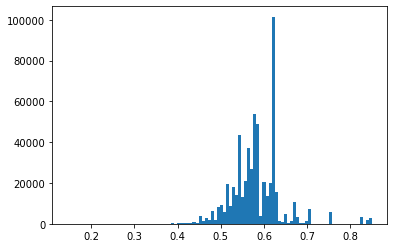

In [448]:
plt.hist(features.both_sim,bins=100)
plt.show()

## old sentence embeddings

### number-output sentence embeddings on test data

In [295]:
## clean up text
STOP_WORDS = STOP_WORDS.union({'ll', 've','s','id'})

# DON'T stem/lemmatize here because the glove_vectors vocabulary doesn't do that
def text_cleaner(s):
    s = re.sub('<[^<]+?>', '', s.lower()) # remove tags
    # remove stop words
    s = re.sub('[^a-z\s\n]', '', s)
    s = s.split()
    # spacy stop words are a little more complete than gsp stop words
    s = [w for w in s if not w in STOP_WORDS]
    return s

In [ ]:
bad_reviews[4]

"Let me start w ordering. I ordered online. Got to the place to pick up my food then bam... my order wasn't ready. They couldn't even find my order. They thought I placed it for another location. Had to show from my phone I placed to round rock location. The guy had to call someone to get my online order. Had to wait an extra 30 min. Place was crowded and big groups of families in there. The food was ok. I wasn't that impressed. I got it to go bc I don't eat in restaurants due to Covid. So by the time I made it home it tasted old. Kind of stale. Like the grease the food was fried in was not fresh. Can't say I'll be back"

In [1153]:
text = bad_reviews[5]
words = text_cleaner(text)
words

['expected',
 'dingy',
 'clean',
 'overall',
 'service',
 'par',
 'focus',
 'serving',
 'bar',
 'tables',
 'table',
 'dirty',
 'sticky',
 'menu',
 'disgusting',
 'touch',
 'food',
 'okay']

In [1303]:
def review2vec(doc, method='list'):
    """
        Applies word2vec on each word of the review
        Returns a list of vectors, oops
    """
    words = []
    keys = []
    for w in doc:
        if w in ('food','like'):
            continue
        try:
            vec = gv[w]
        except KeyError: # if glove doesn't have a vector
            continue
        words.append(vec)
        keys.append(w)
    if words: 
        words = np.asarray(words)
        if method=='mean':
            return np.mean(words,axis=0)
        elif method=='list':
            return words
        elif method=='keys_too':
            return words, keys
    if not words:
        return None

In [1304]:
def vec_similarity(vec1, vec2):
    """
        Dot product of two unit vectors to get similarity between them, same implementation as gensim similarity
    """
    return np.dot(matutils.unitvec(vec1),matutils.unitvec(vec2))

In [1305]:
def review_model(text, output='number', index=0):
    """
        Cleans text, vectorizes words, measures cosine distance to selected DIRTY_WORDS and PEST_WORDS, and calculates aggregate features.
        Output is one 'dirtiness score' if output=='number', else a dataframe
    """
    words = text_cleaner(text)
    vec_list = review2vec(words,'list')
    # return vec_list
    
    # corner case: all words are not in the vocabulary (i.e., different language, short reviews, typo-ridden reviews, etc.)
    if vec_list is None:
        return None

    new_df = pd.DataFrame()
    new_df['dirtiness'] = [vec_similarity(DIRTY_VECTOR, vec) for vec in vec_list]
    new_df['pestiness'] = [vec_similarity(PEST_VECTOR, vec) for vec in vec_list]
    
    if output == 'number': # just get one number for each review
        df_dirt = new_df.agg(
            Top5PercentD = ('dirtiness', lambda x: np.mean(sorted(x)[-math.ceil(len(x)*0.05):])),
        )
        df_pest = new_df.agg(
            Top5PercentP = ('pestiness', lambda x: np.mean(sorted(x)[-math.ceil(len(x)*0.05):])),
        )
        return np.max([
            df_dirt.loc['Top5PercentD'].values,
            df_pest.loc['Top5PercentP'].values
        ])
    elif output == 'vectors':
        for idx, vec in enumerate(vec_list):
            new_df[f'vec_{idx}'] = vec
        return new_df
    else: # return more stats
        df_dirt = new_df.agg(
            MeanD = ('dirtiness', np.mean),
            StderrD = ('dirtiness', lambda x: np.std(x)/len(x)),
            MaxD = ('dirtiness', np.max),
            LEN = ('dirtiness',len),
            # get average of top 5% of words in similarity
            Top5PercentD = ('dirtiness', lambda x: np.mean(sorted(x)[-math.ceil(len(x)*0.05):])),
            Top10PercentD = ('dirtiness', lambda x: np.mean(sorted(x)[-math.ceil(len(x)*0.10):]))
        )
        df_pest = new_df.agg(
            MeanP = ('pestiness', np.mean),
            StderrP = ('pestiness', lambda x: np.std(x)/len(x)),
            MaxP = ('pestiness', np.max),
            # get average of top 5% of words in similarity
            Top5PercentP = ('pestiness', lambda x: np.mean(sorted(x)[-math.ceil(len(x)*0.05):])),
            Top10PercentP = ('pestiness', lambda x: np.mean(sorted(x)[-math.ceil(len(x)*0.10):]))
        )
        df_tot = pd.concat([
            df_dirt.rename({'dirtiness':index},axis=1),
            df_pest.rename({'pestiness':index},axis=1)
        ]).T
        # return np.max([df_dirt.loc['Top5Percent'].values,df_pest.loc['Top5Percent'].values])
        return df_tot

In [1306]:
text

'Expected more. Seemed dingy. Not very clean overall. Service was not up to par. They seemed to be more focus on serving those at the bar then at the tables. Our table was dirty, sticky. Menu was disgusting to the touch. The food was okay. Will not go again.'

In [1307]:
idx = 5
text = bad_reviews[idx]
review_model(text,'list',1)

,MeanD,StderrD,MaxD,LEN,Top5PercentD,Top10PercentD,MeanP,StderrP,MaxP,Top5PercentP,Top10PercentP
1,0.372709,0.011554,0.849937,17.0,0.849937,0.802675,0.247398,0.005244,0.385577,0.385577,0.382334


In [1308]:
corpus = bad_reviews
df_bad = [review_model(text) for text in corpus]
corpus = good_reviews
df_good = [review_model(text) for text in corpus]

In [1309]:
df_bad

[0.7360646009445191,
 0.7117146551609039,
 0.5368978381156921,
 0.7367739379405975,
 0.5889953970909119,
 0.8499367237091064,
 0.6879293123881022,
 0.6618241667747498,
 0.6356184124946594]

In [1310]:
df_good

[0.5786933898925781,
 0.5786933898925781,
 0.5873579978942871,
 0.5306189060211182,
 0.5930044949054718,
 0.5949955185254415,
 0.5763154029846191]

### filter data by language

There are many reviews not in English which mess up the cleanliness score calculation (different language == very clean). Let's take them out.

In [1162]:
from langdetect import DetectorFactory
DetectorFactory.seed = 0
from langdetect import detect, detect_langs

In [1210]:
# language finding doesn't work well with only a few words
df_filtered = df[df.text.apply(len) >= 10]

In [1211]:
%%time
languages = df_filtered['text'].apply(detect)

CPU times: total: 26min 56s
Wall time: 26min 57s


In [1212]:
df_lang = df_filtered.copy()
df_lang['language'] = languages

In [1213]:
df_lang.to_csv(processed_data_directory + 'reviews_nearest_score_no_limit_df_languages.csv', index=False)

### run on all reviews

In [1315]:
df = pd.read_csv(processed_data_directory + 'reviews_nearest_score_no_limit_df_languages.csv')
print(len(df))
df = df[df.language == 'en']
print(len(df))

570596
569998


In [1316]:
X = df.text.values

In [1318]:
%%time
corpus = df.text.values
dirty_scores = np.array([review_model(text) for text in corpus])

CPU times: total: 44min 43s
Wall time: 44min 44s


In [1319]:
df_test = df.copy()
df_test['predict'] = dirty_scores

In [1320]:
df_test.to_csv(model_directory + 'review_model/top5percent_per_review.csv',index=False)

### concat all reviews for each business

In [ ]:
all_bad_reviews = ' '.join(bad_reviews)
vec_list, keys_list = review2vec(text_cleaner(all_bad_reviews),'keys_too')

In [ ]:
new_df = pd.DataFrame()
new_df['dirtiness'] = [vec_similarity(DIRTY_VECTOR, vec) for vec in vec_list]
new_df['pestiness'] = [vec_similarity(PEST_VECTOR, vec) for vec in vec_list]
new_df['vec'] = list(vec_list)
new_df['word'] = list(keys_list)

In [ ]:
print(new_df[new_df.dirtiness > np.quantile(new_df.dirtiness,0.8)].word.values)
print(new_df[new_df.pestiness > np.quantile(new_df.pestiness,0.8)].word.values)

['absolutely' 'disgusting' 'odd' 'smell' 'tasted' 'fried' 'looking'
 'fried' 'looked' 'obviously' 'honestly' 'eat' 'gross' 'getting' 'sick'
 'throw' 'worst' 'absolutely' 'way' 'lot' 'instead' 'absolutely'
 'horrible' 'dirty' 'pretty' 'good' 'cold' 'confused' 'weird' 'ill' 'lot'
 'looked' 'having' 'cant' 'literally' 'disgusting' 'rude' 'hell' 'know'
 'eat' 'actually' 'worst' 'thought' 'guy' 'dont' 'eat' 'tasted' 'old'
 'kind' 'stale' 'fried' 'cant' 'ill' 'clean' 'dirty' 'sticky' 'disgusting'
 'good' 'kinda' 'mess' 'fish' 'spoiled' 'smell' 'smell' 'dont' 'sick'
 'definitely' 'cant' 'look' 'awful' 'taste' 'smell' 'slimy' 'supposed'
 'old' 'tasted' 'old' 'old' 'eating' 'extremely' 'right' 'better' 'going']
['place' 'disgusting' 'smell' 'type' 'stick' 'looking' 'threw' 'puppies'
 'eat' 'fear' 'getting' 'sick' 'throw' 'got' 'worst' 'gone' 'way' 'place'
 'weird' 'ill' 'came' 'room' 'small' 'water' 'person' 'came' 'walk'
 'place' 'left' 'having' 'cant' 'literally' 'disgusting' 'hell' 'know'
 '

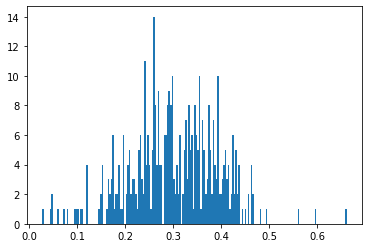

In [ ]:
plt.hist(new_df.pestiness,bins=200)
plt.show()

In [661]:
df.groupby('business_id','Score'

,business_id,review_id,text,date,review_stars,Score,stars
0,NRPemqVb4qpWFF0Avq_6OQ,058Ifx7-wXugpY2CO3X4gA,We went tonight following our favorite new Sus...,2017-03-17 01:53:14,5,76.0,4.5
1,NRPemqVb4qpWFF0Avq_6OQ,iqgH--t6KCxocbniQE87EQ,First Indonesian Owned restaurant I found that...,2017-03-18 22:03:24,5,76.0,4.5
2,NRPemqVb4qpWFF0Avq_6OQ,sCZ7J-35Ro4FHEXBmUShHw,A great addition to the area! Personnel are ve...,2017-03-19 23:45:12,5,76.0,4.5
3,NRPemqVb4qpWFF0Avq_6OQ,jmfkhC53ETKV3Dzsq7bBOw,Pleasantly surprised by the energy that went i...,2017-03-21 19:34:06,5,76.0,4.5
4,NRPemqVb4qpWFF0Avq_6OQ,bzZ-Ei2AQDI7uEfnUv6R0g,Good food and very friendly wait staff. Best s...,2017-03-22 00:28:22,5,76.0,4.5
...,...,...,...,...,...,...,...
570609,EaBDXdIQ_TeeUhn1Twnjvg,o7KKw9gZ1zADWR3OvwJOjQ,I've heard only good things about this noodle ...,2019-10-28 02:35:05,5,73.0,3.5
570610,EaBDXdIQ_TeeUhn1Twnjvg,vKLOotHW3NGAWGd_AKmrxw,I've had a very hot or miss experience with sh...,2019-11-20 00:57:20,4,73.0,3.5
570611,EaBDXdIQ_TeeUhn1Twnjvg,RqU0sEZcHc25RWap4v9_5A,The best Chinese food we have found in the are...,2019-11-23 21:38:24,5,73.0,3.5
570612,EaBDXdIQ_TeeUhn1Twnjvg,zvZR61Ioy-5dhw_3Q3kPFw,This is a small and simple restaurant but such...,2020-01-17 01:25:08,5,73.0,3.5


In [643]:
df_concat = df.groupby(['business_id','Score']).agg(
    Concat_text = ('text', lambda x: ' '.join(x))
).reset_index()

In [658]:
%%time
df_concat.Concat_text[0:10].apply(review_model)

CPU times: total: 547 ms
Wall time: 541 ms


0    0.587708
1    0.416375
2    0.565273
3    0.586738
4    0.569732
5    0.569019
6    0.563806
7    0.595096
8    0.568131
9    0.568271
Name: Concat_text, dtype: float64

In [660]:
df_concat[0:10]

,business_id,Score,Concat_text
0,-0TbQsmE2p1bhG30rgvK2Q,93.0,"It's right across the street from my condo, so..."
1,-0TbQsmE2p1bhG30rgvK2Q,95.0,RiverCity Market has hands-down the best craft...
2,-0TbQsmE2p1bhG30rgvK2Q,98.0,Awesome beer and wine selection! Nice little s...
3,-4bP1UUgpZumIu6DZMaMzw,86.0,I see a pattern here.\n\nNice-looking shop. Lo...
4,-4bP1UUgpZumIu6DZMaMzw,95.0,Houndstooth has always been fantastic! The bar...
5,-4cQ12xutjNLW-tPI06_tg,88.0,I went in 2 hours before closing and they said...
6,-4cQ12xutjNLW-tPI06_tg,89.0,Y'all this place goes ooooooooffffff. I came i...
7,-4cQ12xutjNLW-tPI06_tg,94.0,Unless you've been a pro stunt driver or done ...
8,-4cQ12xutjNLW-tPI06_tg,96.0,The food is good. Tacos are amazing. You never...
9,-4cQ12xutjNLW-tPI06_tg,100.0,"During our vacation to Austin, we came here in..."


In [655]:
%%time
df_concat['dirtiness'] = df_concat.Concat_text.apply(review_model)

KeyboardInterrupt: 

# Other ideas

## doc2vec

Any single word embedding technique is just bag of words in the end on a sentence. There are more complicated ways to incorporate word embeddings for sentences, but implementing those is not worth it for our data set.

Gensim has a Doc2Vec model which extends word2vec to the document level. There aren't many pre-trained doc2vec models/vectors, but this answer https://stackoverflow.com/a/31417164 makes it sound like it's not that bad of an idea to feed pre-trained word2vec models into doc2vec. I'm not so sure.

Some pre-trained Doc2Vec models on wikipedia and AP news https://github.com/jhlau/doc2vec. Not sure how much this helps, since the glove word embeddings trained on colloquial twitter text would be closer to yelp review text.

## contextual models: BERT and ELMo

Word2vec is context-free and looks only at single word embedding. It might make more sense to look at contextual models like BERT and Elmo

Using bert https://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/